In [71]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, roc_auc_score, ConfusionMatrixDisplay
)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
#print(os.getcwd())
#if os.path.basename(os.getcwd()) != 'NeuroCurve': os.chdir('NeuroCurve')

## Processing

In [72]:
os.chdir('..')
NeuroCurveOG = pd.read_csv("CSV/alzheimers_disease_data.csv")
"Drops any unnecessary features of the original dataset"
def pre_process():
    usableCSV = NeuroCurveOG.drop(columns=["PatientID", "Diabetes", "CardiovascularDisease", "DoctorInCharge", "Depression", "Depression", "SystolicBP", "DiastolicBP"])
    usableCSV.to_csv('CSV/output_CSVs/processed.csv')
pre_process()
usableCSV = pd.read_csv('CSV/output_CSVs/processed.csv')
os.chdir('NeuroPy')

X = usableCSV.drop(columns=['Diagnosis', 'Unnamed: 0'])
y = usableCSV['Diagnosis']

categorical_cols = ['Gender', 'Ethnicity', 'FamilyHistoryAlzheimers']
X[categorical_cols] = X[categorical_cols].astype('category')
X = pd.get_dummies(X, drop_first=True)  # One-hot encoding

''' Scale features '''
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Model Test Split


In [73]:
''' ----------- Train/Test Split ----------- '''
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

## Training

In [74]:
''' ----------- Logistic Model Training ----------- '''
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

'''------------- Decision Tree Model Training ---------'''
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)


'''------------ Mythical Forest Model Training---------'''
forest = RandomForestClassifier(n_estimators=len(X_train), random_state=42)
forest.fit(X_train, y_train)

'''---------- Forest K-Fold Model Training --------'''
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(forest, X_scaled, y, cv=kf, scoring='accuracy')
print("Cross-validated accuracy:", scores.mean())

Cross-validated accuracy: 0.9474169241611101


## Analysis

Modeling

In [75]:
''' ----------- Logistic Model Training ----------- '''
y_prob_log = model.predict_proba(X_test)
#print("Predicted probabilities for the first 5 examples:\n", y_prob_log[:5])
y_pred_log = model.predict(X_test)
#print(f"y_pred: {y_pred_log[:5]}")
#print(f"y_test: {y_test.values[:5]}")
accuracy = accuracy_score(y_test, y_pred_log)
print(f"Accuracy: {accuracy * 100:.2f}%")


'''------------- Decision Tree Model Training ---------'''
y_pred_tree = tree.predict(X_test)
y_prob_tree = tree.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred_tree)
print(f"Accuracy: {accuracy * 100:.2f}%")


'''------------ Mythical Forest Model Training---------'''
y_prob_forest = forest.predict_proba(X_test)
#print("Predicted probabilities for the first 5 examples:\n", y_prob_forest[:5])
y_pred_forest = forest.predict(X_test)
#print(f"y_pred: {y_pred_forest[:5]}")
#print(f"y_test: {y_test.values[:5]}")
accuracy = accuracy_score(y_test, y_pred_forest)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 81.40%
Accuracy: 90.47%
Accuracy: 94.88%


## Visualization

### Confusion Matrix

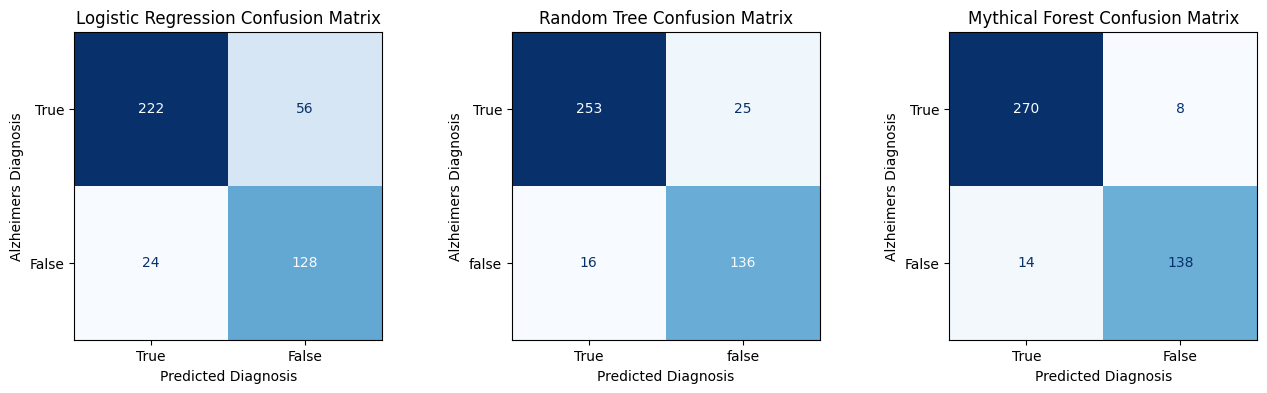

In [76]:
figs, axes = plt.subplots(1, 3, figsize=(16,4))

''' ----------- Logistic Model Training ----------- '''
cm = confusion_matrix(y_test, y_pred_log)
disp1 = ConfusionMatrixDisplay(cm, display_labels=["True", "False"])
disp1.plot(ax=axes[0], colorbar=False, cmap="Blues")

axes[0].set_title("Logistic Regression Confusion Matrix")
axes[0].set_ylabel("Alzheimers Diagnosis")
axes[0].set_xlabel("Predicted Diagnosis")



'''------------- Decision Tree Model Training ---------'''
cm1 = confusion_matrix(y_test, y_pred_tree)
disp2= ConfusionMatrixDisplay(cm1, display_labels=["True", "false"])
disp2.plot(ax=axes[1], colorbar=False, cmap="Blues")

axes[1].set_title("Random Tree Confusion Matrix")
axes[1].set_ylabel("Alzheimers Diagnosis")
axes[1].set_xlabel("Predicted Diagnosis")



'''------------ Mythical Forest Model Training---------'''
cm2 = confusion_matrix(y_test, y_pred_forest)
disp3 = ConfusionMatrixDisplay(cm2, display_labels=["True", "False"])
disp3.plot(ax=axes[2], colorbar=False, cmap="Blues")

axes[2].set_title("Mythical Forest Confusion Matrix")
axes[2].set_ylabel("Alzheimers Diagnosis")
axes[2].set_xlabel("Predicted Diagnosis")


plt.show()

### Classification Report: Logistic Regression

In [77]:
printouts = ["Logistic Regression", "Decision Tree", "Mythical Forest"]
cr = {"Logistic Regression":y_pred_log, "Decision Tree":y_pred_tree, "Mythical Forest":y_pred_forest}


for p in printouts:
    print(f"{p} Classification Report:\n{classification_report(y_test, cr[p])}-----------------------------------------------------\n\n")


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       278
           1       0.70      0.84      0.76       152

    accuracy                           0.81       430
   macro avg       0.80      0.82      0.80       430
weighted avg       0.83      0.81      0.82       430
-----------------------------------------------------


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       278
           1       0.84      0.89      0.87       152

    accuracy                           0.90       430
   macro avg       0.89      0.90      0.90       430
weighted avg       0.91      0.90      0.91       430
-----------------------------------------------------


Mythical Forest Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       278
        

### Mythical Forest Confusion Matrix

### Classification Report: Mythical Forest

In [78]:
print("Classification Report:")
print(classification_report(y_test, y_pred_forest))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       278
           1       0.95      0.91      0.93       152

    accuracy                           0.95       430
   macro avg       0.95      0.94      0.94       430
weighted avg       0.95      0.95      0.95       430



### Logistic Regression ROC Curve

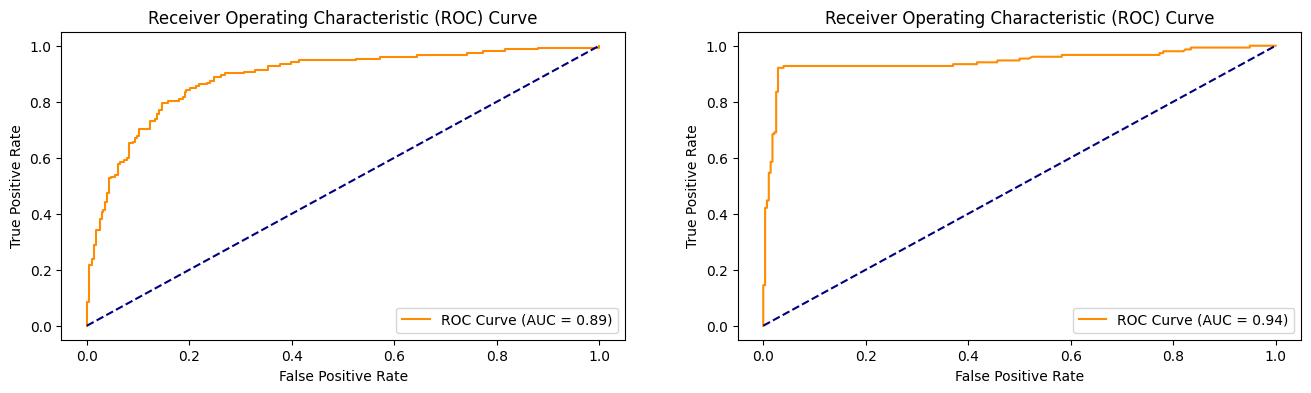

In [79]:

fig,axes = plt.subplots(1,2,figsize=(16,4))

''' ----------- Logistic Regression ROC Curve ----------- '''
y_prob_class1 = y_prob_log[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_class1)
roc_auc = roc_auc_score(y_test, y_prob_class1)
axes[0].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
axes[0].plot([0, 1], [0, 1], color='navy', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[0].legend(loc="lower right")

''' ----------- Mythical Forest ROC Curve ----------- '''
y_prob_forest = y_prob_forest[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_forest)
roc_auc = roc_auc_score(y_test, y_prob_forest)
axes[1].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
axes[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[1].legend(loc="lower right")

plt.show()

### Mythical Forest ROC Curve

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:



"""
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000), param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)
"""

'\nparam_grid = {\n    \'C\': [0.01, 0.1, 1, 10],\n    \'penalty\': [\'l1\', \'l2\'],\n    \'solver\': [\'liblinear\']\n}\ngrid = GridSearchCV(LogisticRegression(class_weight=\'balanced\', max_iter=1000), param_grid, cv=5, scoring=\'roc_auc\')\ngrid.fit(X_train, y_train)\nprint("Best Parameters:", grid.best_params_)\n'